

# <h1 align="center"> Image Segmentation (Helper Notebook)
 </h1>

<hr />
<center>Constructor Academy, 2024</center>

**图像分割分为两种主要类型：**

- 语义分割（Semantic Segmentation）：对图像中的像素进行分类，但不区分具体实例。这意味着，所有属于同一类的物体（例如，图中的所有猫）都会被分到同一个类别中，而不会区分是不同的个体。

- 实例分割（Instance Segmentation）：不仅对图像中的每个像素进行分类，还区分不同实例。比如，同一张图中，如果有多只猫，每只猫会有独立的掩码标签。

**U-Net 进行的是哪种分割？**
- U-Net 通常用于 语义分割（Semantic Segmentation），即 不区分实例，而是为图像中的每个像素分配一个类别标签，所有属于相同类别的像素都会被划分到同一个类中。

This tutorial focuses on the task of image segmentation, using a <a href="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/" class="external">U-Net</a>.

## What is image segmentation?
So far you have seen image classification, where the task of the network is to assign a label or class to an input image. However, suppose you want to know where an object is located in the image, the shape of that object, which pixel belongs to which object, etc.

There are various types of segmentation, however we will focus on single image semantic segmentation which basically focuses on pixel-wise segmentation.

![](https://i.imgur.com/vaAAK2E.png)

In this case you will want to segment the image, __i.e., each pixel of the image is given a label.__

Thus, the task of image segmentation is to __train a neural network to output a pixel-wise mask of the image__. This helps in understanding the image at a much lower level, i.e., the pixel level.

Image segmentation has many applications in medical imaging, self-driving cars and satellite imaging to name a few.

The dataset that will be used for this tutorial is the [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/), created by Parkhi *et al*. The dataset consists of images, their corresponding labels, and pixel-wise masks. The masks are basically labels for each pixel. Each pixel is given one of three categories :

*   Class 1 : Pixel belonging to the pet.
*   Class 2 : Pixel bordering the pet.
*   Class 3 : None of the above/ Surrounding pixel.

本教程使用 <a href=“https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/” class=“external”>U-Net</a> 专注于图像分割任务。

### 什么是图像分割？
到目前为止，您已经看到了图像分类，其中网络的任务是为输入图像指定一个标签或类别。但是，假设您想知道某个物体在图像中的位置、该物体的形状、哪个像素属于哪个物体等。

分割有多种类型，但我们将重点讨论单幅图像语义分割，它基本上侧重于像素分割。

![](https://i.imgur.com/vaAAK2E.png)

在这种情况下，您需要对图像进行分割，__即给图像的每个像素一个标签。

因此，图像分割的任务是__训练一个神经网络来输出图像的像素掩码__。这有助于从更低的层面，即像素层面理解图像。

图像分割在医学成像、自动驾驶汽车和卫星成像等领域有很多应用。

本教程将使用的数据集是Parkhi *et al*创建的[牛津-IIT宠物数据集](https://www.robots.ox.ac.uk/~vgg/data/pets/)。该数据集由图像、相应标签和像素掩码组成。掩码基本上是每个像素的标签。每个像素分为三类：

* 第 1 类：属于宠物的像素。
* 第 2 类：与宠物接壤的像素。
* 第 3 类：非上述像素/周围像素。

In [1]:
!nvidia-smi

Sat Oct  5 10:21:01 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P0             26W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

## Download the Oxford-IIIT Pets dataset

With just one line of code, we can use tfds to load the dataset by specifying the name of the dataset, and get the dataset info by setting `with_info=True`.

The segmentation masks are included in version 3+.

下载牛津大学-麻省理工学院宠物数据集
只需一行代码，我们就能通过指定数据集名称使用 tfds 加载数据集，并通过设置 with_info=True 获取数据集信息。

分割掩码包含在 3+ 版本中。

备注：Oxford-IIIT Pets 数据集在 TensorFlow Datasets (tfds) 中已经预先划分好了训练集和测试集，而且分割掩码在 v3+ 版本中已经包含在数据集中。

In [3]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.D6CL1X_3.2.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.D6CL1X_3.2.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [4]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir=PosixGPath('/tmp/tmpe256fiy8tfds'),
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        '

We can see there are a total of 7349 images with a built-in test/train split.
我们可以看到，共有 7349 幅图像进行了内置的测试/训练分割。


补充：** U-Net 模型**不是一个用于模型迁移的模型，而是一种专门设计用于图像分割任务的卷积神经网络（CNN）架构。它最初是在医学图像分割领域中提出的，但由于其强大的表现，现在已经被广泛应用于各种图像分割任务中。

## Image Pre-processing and Augmentation

图像预处理和增强
We will apply some transformations to the downloaded dataset before we start training our U-Net model with it.


在开始训练 U-Net 模型之前，我们将对下载的数据集进行一些转换。




First, we resize the images and masks to `128x128` 首先，我们将图像和遮罩的大小调整为 128x128

In [5]:
def resize(input_image, input_mask):
    # 使用最近邻插值法将输入图像调整为128x128
    input_image = tf.image.resize(input_image, (128, 128), method='nearest')

    # 使用最近邻插值法将输入掩码调整为128x128
    input_mask = tf.image.resize(input_mask, (128, 128), method='nearest')

    # 返回调整后的图像和掩码
    return input_image, input_mask


# 图像和分割掩码重新调整为 128x128 的原因通常与神经网络模型的输入要求和计算资源的限制有关
# 分割掩码是图像分割任务的输出结果，用于标识每个像素所属的类别或区域。它是一种用于训练和推理的标签，用来告诉模型每个像素对应的实际分类结果。

# 在图像分割任务中，每个像素都需要被分类到某个类别中。例如，在语义分割中，可能有以下几种类别：
# 类别 0：背景
# 类别 1：道路
# 类别 2：汽车
# 类别 3：行人

# 在图像分割任务中，图像和分割掩码必须保持相同的尺寸，这是因为每个像素只能有一个类别，并且分割掩码用于表示每个像素所属的类别。

Then we create a function to augment the dataset by flipping them horizontally (keeping augmentation simple here)
然后，我们创建一个函数，通过水平翻转数据集来增强数据集（此处保持增强的简单性）

In [6]:
#数据增强（augmentation）是一种常见的技术，通过对原始数据进行一些随机变换（如翻转、旋转、缩放等），可以生成更多的训练样本，从而提高模型的泛化能力。


def augment(input_image, input_mask):
    # 如果生成的随机数大于0.5，则对图像和掩码进行随机水平翻转
    # 这是用来引入随机性的。如果生成的随机数大于 0.5，则对图像和掩码进行水平翻转。这样可以保证增强过程是随机的，有时图像会翻转，有时则不会。

    if tf.random.uniform(()) > 0.5:
        # 对图像进行随机水平翻转
        input_image = tf.image.flip_left_right(input_image)
        # 对掩码进行随机水平翻转
        # 当图像的位置发生改变时，对应的标签（掩码）的像素位置也必须同步改变，以确保标签正确地对应到图像中相应的物体或类别。
        input_mask = tf.image.flip_left_right(input_mask)

    # 返回增强后的图像和掩码
    return input_image, input_mask


# 补充：
# 是的，你可以使用 keras.Sequential 来构建数据增强管道，这是一种更简洁和可扩展的方法，尤其是在处理多个数据增强操作时。
# 相较于你之前的 augment 函数，keras.layers 提供了更多的内置数据增强层（如 RandomFlip, RandomRotation, RandomZoom），而且这种方法与 Keras 模型的构建方式高度一致。

Next, the images are normalized to [0,1].

Finally, as mentioned above the pixels in the segmentation mask are labeled either {1, 2, 3}.

For the sake of convenience, let's subtract 1 from the segmentation mask, resulting in labels that are : {0, 1, 2}.

然后，将图像归一化为 [0,1]。

最后，如上所述，分割掩码中的像素被标记为{1, 2, 3}。

为了方便起见，我们从分割掩码中减去 1，得到的标签为 ： {0, 1, 2}.

In [7]:
import tensorflow as tf

def normalize(input_image, input_mask):
    # 将输入图像转换为 float32 类型，并将像素值归一化到 [0, 1] 区间
    input_image = tf.cast(input_image, tf.float32) / 255.0

    # 将掩码中的每个像素值减去 1，使类标签从 0 开始，即 0, 1, 2
    # 掩码中的每个像素值减去 1 是为了将类别标签从 1 开始的索引调整为从 0 开始的索引。
    # 大多数深度学习框架（如 TensorFlow、Keras）中，分类问题的类别标签通常是从 0 开始的。例如，对于 3 个类别的分割任务，类别标签通常是 0、1 和 2，而不是 1、2 和 3。

    input_mask -= 1

    # 返回归一化后的图像和调整后的掩码
    return input_image, input_mask


We create two functions now to preprocess the training and test datasets.

The functions have a slight difference between them – we only perform image augmentation on the training dataset.

我们现在创建两个函数来预处理训练数据集和测试数据集。

这两个函数略有不同--我们只对训练数据集进行图像增强。

In [8]:
def load_image_train(datapoint):
    # 从数据点中提取图像
    input_image = datapoint["image"]
    # 从数据点中提取分割掩码
    input_mask = datapoint["segmentation_mask"]

    # 调整图像和掩码的大小
    input_image, input_mask = resize(input_image, input_mask)

    # 对图像和掩码进行数据增强（如随机翻转）
    input_image, input_mask = augment(input_image, input_mask)

    # 对图像进行归一化处理，将掩码的标签调整为从0开始
    input_image, input_mask = normalize(input_image, input_mask)

    # 返回处理后的图像和掩码
    return input_image, input_mask


def load_image_test(datapoint):
    # 从数据点中提取图像
    input_image = datapoint["image"]
    # 从数据点中提取分割掩码
    input_mask = datapoint["segmentation_mask"]

    # 调整图像和掩码的大小
    input_image, input_mask = resize(input_image, input_mask)

    # 对图像进行归一化处理，将掩码的标签调整为从0开始
    input_image, input_mask = normalize(input_image, input_mask)

    # 返回处理后的图像和掩码
    return input_image, input_mask


The dataset already contains the required splits of test and train and so let's continue to use the same split.

数据集已包含测试和训练所需的拆分，因此让我们继续使用相同的拆分。

We are now ready to build an input pipeline with tf.data by using the `map()` function



现在，我们可以使用 map() 函数利用 tf.data 建立输入管道了

In [9]:
# 这段代码用于对已经分好的训练和测试数据集进行预处理，并为后续的数据处理管道做好准备。

# 使用 map() 函数对训练集进行预处理，应用 load_image_train 函数
train_dataset = dataset["train"].map(load_image_train,
                                     num_parallel_calls=tf.data.AUTOTUNE)
                                     # 将 load_image_train 函数应用到训练数据集的每个样本上，进行数据预处理操作（如图像调整、归一化和数据增强）。


# 使用 map() 函数对测试集进行预处理，应用 load_image_test 函数
test_dataset = dataset["test"].map(load_image_test,
                                   num_parallel_calls=tf.data.AUTOTUNE)
                                   # 将 load_image_test 函数应用到测试数据集的每个样本上，进行数据预处理操作（如图像调整和归一化），但通常不会进行数据增强。
                                   # num_parallel_calls=tf.data.AUTOTUNE：使用自动优化功能并行处理测试数据集，以加快处理速度。



We define a batch size of 64 and a buffer size of 4000 for creating batches of training and test datasets.

With the original TFDS dataset, there are 3680 training samples and 3669 test samples, which are further split into validation/test sets.

We will use the train_batches and the validation_batches for training the U-Net model.

After the training finishes, we will then use the test_batches to test the model predictions.

我们将创建训练和测试数据集的批次大小定义为 64，缓冲区大小为 4000。

原始的 TFDS 数据集有 3680 个训练样本和 3669 个测试样本，这些样本又被分为验证集和测试集。

我们将使用训练批次和验证批次来训练 U-Net 模型。

训练完成后，我们将使用 test_batches 测试模型的预测结果。

In [10]:
# 这段代码旨在对训练、验证和测试数据集进行批处理，优化了性能并合理分配数据集用于训练、验证和测试。

BATCH_SIZE = 64  # 设置批处理的大小为64
                 # 当 BATCH_SIZE=64 时，每次训练模型的时候，会从数据集中提取 64 张图片（以及它们对应的掩码）作为一个小批次（mini-batch）输入给模型。
                 # 例如，如果你有 10000 张训练图片，BATCH_SIZE=64 意味着每次只会处理 64 张图片，训练一轮（称为 epoch）需要进行 10000 / 64 = 156.25 次迭代。
                 # 为什么要使用批次？
                        # 内存优化：一次处理整个数据集可能会耗尽内存。将数据集分成小批次后，可以一次只处理一小部分数据。
                        # 计算效率：批量处理多个样本（而不是一个样本）能更有效地利用硬件资源（如 GPU），提高训练速度。
                        # 梯度更新：批次中的样本会共同参与一次模型权重更新，批量处理的梯度通常比逐样本的梯度更平滑，更有利于稳定训练。

BUFFER_SIZE = 4000  # 设置用于打乱数据集时的缓冲区大小为4000
                    # BUFFER_SIZE=4000 表示在打乱数据时，系统会从数据集中取出 4000 个样本放入一个缓冲区（buffer），然后从这个缓冲区中随机取出样本来形成训练批次（batch）。随着缓冲区中样本的消耗，系统会不断从数据集中取入新的样本填充缓冲区。
                    # 这个参数定义了打乱数据的程度。BUFFER_SIZE 越大，数据打乱得越彻底；但同时也需要更多的内存。
                    # 为什么要打乱数据集：1）防止过拟合 2）提高训练的随机性


# 对训练集进行缓存、打乱、批处理和重复处理
train_batches = train_dataset.cache()  # 将数据集缓存到内存中，提升读取速度
train_batches = train_batches.shuffle(BUFFER_SIZE)  # 随机打乱数据集，使用缓冲区
train_batches = train_batches.batch(BATCH_SIZE).repeat()  # 将数据集按批次处理，并无限重复


# 使用 prefetch 提前准备数据，以提升训练过程中的性能
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


# 将原本的 测试集（test_dataset） 划分为两个部分：验证集（validation set） 和 测试集（test set）。
# 前 3000 个样本作为验证集，接下来的 669 个样本作为测试集。

# 对验证集处理，获取前3000个样本并进行批处理
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)

# 对测试集处理，跳过前3000个样本，获取接下来的669个样本并进行批处理
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)


Now the datasets are ready for training. Let’s visualize a random sample image and its mask from the training dataset, to get an idea of how the data looks.​​

现在，训练数据集已经准备就绪。让我们对训练数据集中的随机样本图像及其遮罩进行可视化，以了解数据的外观。

In [11]:
def display(display_list):
    # 创建一个图形窗口，大小设置为15x15
    plt.figure(figsize=(15, 15))

    # 定义每个子图的标题：输入图像、真实掩码和预测掩码
    title = ["Input Image", "True Mask", "Predicted Mask"]
                          # 真实掩码来自数据集，是预先标注好的正确答案（数据标签）。预测掩码是模型运行后的输出结果。


    # 遍历显示列表中的图像，分别显示它们
    for i in range(len(display_list)):
        # 在图形中添加子图，按顺序排列
        plt.subplot(1, len(display_list), i+1)

        # 设置每个子图的标题
        plt.title(title[i])

        # 将每个图像显示在子图中，使用 array_to_img 转换为图像格式
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
                         # 在 TensorFlow 中，图像通常以张量的形式存储，张量的数据类型是数值数组，而不是普通图像格式（如 PNG、JPG）。
                         # 为了在 matplotlib 中可视化这些张量，需要将它们转换为标准的图像格式。
                         # array_to_img 会将一个张量或数组的像素值（通常是归一化到 [0, 1] 之间的浮点数）转换成一个可以被绘制的图像对象。


        # 隐藏坐标轴
        plt.axis("off")

    # 显示图像
    plt.show()

    # 现在我在可视化输入图像和真实的掩码，但你还没有真正训练模型或者使用模型进行预测，因此在这一阶段，你不会看到“预测掩码”。


    # 这段代码的意义在于可视化输入图像、真实掩码和模型预测掩码。它的作用是帮助你直观地评估模型的性能。
    # 具体来说：
          # 输入图像：显示你输入到模型中的原始图像。
          # 真实掩码：显示该图像的真实分割结果，也就是数据集中标注的正确答案。
          # 预测掩码：显示模型对输入图像的分割结果（模型的输出）。
          # 通过将这三者并排展示，你可以非常直观地看到模型的表现：
                # 如果预测掩码和真实掩码高度重合，说明模型表现很好。
                # 如果两者差别很大，说明模型在这个样本上的表现较差，可能需要进一步改进模型或数据。

In [12]:
sample_batch = next(iter(train_batches))


# 这段代码从 train_batches 数据集中获取下一个批次的数据。
      # 为什么使用“下一个批次”而不是“这一个批次”？
      # 每当我们从迭代器中调用 next() 时，实际上是从数据流中取出当前尚未处理的那个批次，也就是下一个批次。
      # 换句话说，next() 会推进迭代器，使其获取数据集中尚未处理的那一部分，因此称为**“下一个批次”**。


# train_batches 是一个由 tf.data.Dataset 构建的批次数据流。
# 由于 train_batches 是一个可迭代对象（迭代器），可以用 iter() 将其转化为 Python 的迭代器，然后通过 next() 获取其中的下一批数据。
# iter() 是 Python 的内置函数，它的主要作用是将可迭代对象转化为迭代器，从而可以使用 next() 函数逐个获取其中的元素。

# 这段代码会取出一个小批次（mini-batch）的图像和掩码，并将它们存储在 sample_batch 中。

# 这行代码的作用是从训练数据集train_batches中获取一个小批次的图像和它们对应的分割掩码。你可以用这些图像和掩码来做可视化，或者将它们输入到模型中进行训练或评估。

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


In [13]:
sample_batch[0].shape

# 批次中的输入图像，表示有 64 张 RGB 图像，尺寸为 128x128。 表示图片有 3 个通道（通常是 RGB 图像的通道数，分别表示红、绿、蓝三个颜色通道）。

TensorShape([64, 128, 128, 3])

In [14]:
sample_batch[1].shape

    # 批次中的对应真实掩码，表示有 64 个分割掩码，尺寸为 128x128，每个像素点只有一个标签。
    # 是与这些图像对应的**真实掩码**（用于训练或验证时的“正确答案”）。

    # 注意：这不是指取第一张或第二张图片，而是指这个批次中包含的所有图片和它们的掩码。
    # 在 TensorFlow 中，数据集（例如通过 tf.data.Dataset 加载的数据）通常是包含图像和标签的元组 (image, label)：
      # image：是输入数据，通常是用于训练模型的输入图像。
      # label：是标签数据，通常用于监督学习中的目标，像图像分类中的类别标签，或图像分割任务中的分割掩码。

    # 在数据集中，当数据对被加载时，它们通常以一个元组的形式存储。例如，在图像分割任务中，通常将输入图像和对应的掩码组织成元组 (input_image, mask)。
    # 0 对应图像：因为图像是输入数据，通常在数据集中是第一个元素。
    # 1 对应真实掩码：因为掩码是标签数据，用于监督模型学习，通常放在数据集元组中的第二个位置。
    # 这种数据结构（(input_image, mask)）是深度学习框架（如 TensorFlow）中的常见模式，方便模型在训练过程中处理输入数据和标签数据。

TensorShape([64, 128, 128, 1])

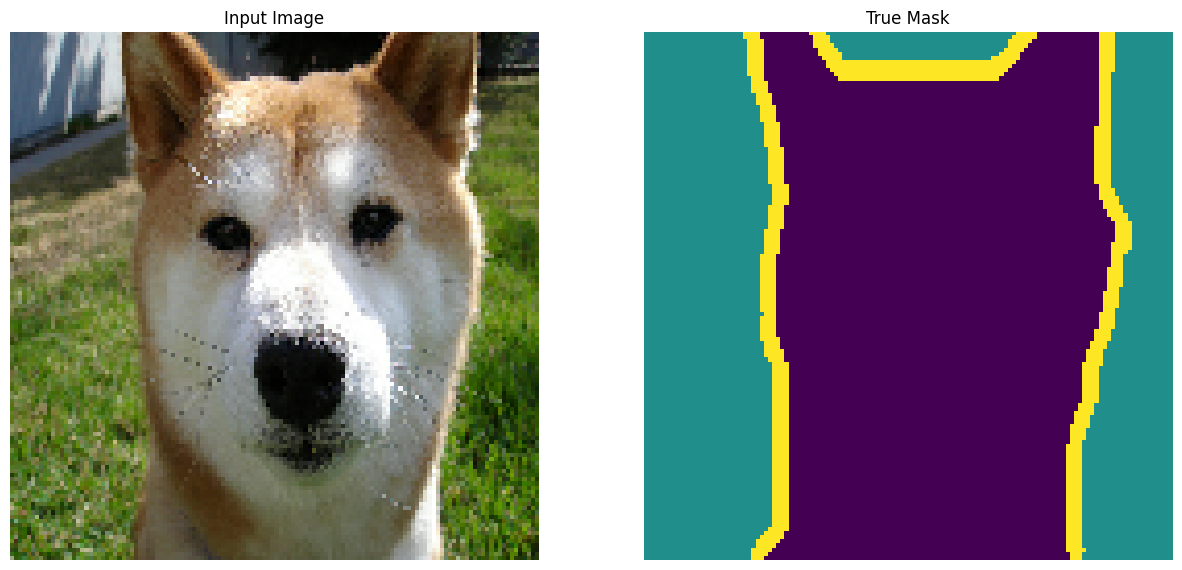

In [15]:
# 这段代码的主要作用是从当前的训练批次中随机选择一张图像及其对应的分割掩码，并通过 display() 函数进行可视化。
# 这可以帮助你快速查看训练数据和标签的正确性，确保图像和掩码数据的预处理操作没有问题。


# 从 sample_batch[0] 的第一个维度中随机选择一个索引
# sample_batch[0].shape[0] 表示批次中的样本数，即 64（批处理大小）
random_index = np.random.choice(sample_batch[0].shape[0])

# 根据随机选择的索引，从 sample_batch 中提取对应的图像和真实掩码
# sample_image 是随机选中的图像，sample_mask 是该图像对应的分割掩码
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]

# 使用 display 函数显示该图像及其对应的真实掩码
display([sample_image, sample_mask])


In [16]:
sample_image.shape, sample_mask.shape

(TensorShape([128, 128, 3]), TensorShape([128, 128, 1]))

## Define the model

Now that we have the data ready for training, let’s define the U-Net model architecture.

As mentioned earlier, the U-Net is shaped like a letter U with an encoder, decoder, and the skip connections between them.

![](https://i.imgur.com/lDfMAbI.png)

So we will create a few building blocks to make the U-Net model.

定义模型
现在我们已经准备好了用于训练的数据，让我们来定义 U-Net 模型架构。

如前所述，U-Net 的形状就像一个字母 U，包含编码器、解码器和它们之间的跳转连接。

## Building blocks

First, we create a function `double_conv_block` with layers __`Conv2D-ReLU-Conv2D-ReLU`__, which we will use in both the encoder (or the contracting path) and the bottleneck of the U-Net.

构建模块
首先，我们创建一个具有 Conv2D-ReLU-Conv2D-ReLU 层的 double_conv_block 函数，我们将在 U-Net 的编码器（或收缩路径）和瓶颈中使用该函数。



In [17]:
# double_conv_block 的主要作用是通过连续两次卷积操作来提取图像的特征。

# double_conv_block(x, n_filters) 是 U-Net 模型中常见的一个功能模块。这个函数的主要作用是通过两次卷积操作提取输入特征图的高级特征，并且将其输出作为下一个层或模块的输入。
# 在深度学习的卷积神经网络中，卷积层是用来提取图像中的特征的，而双卷积操作能够提取出更加丰富和复杂的特征信息。
# 为什么 double_conv_block 既用于编码器又用于解码器？
       # 特征提取能力强：双卷积可以提取更加复杂和有用的特征，不论是在编码器中提取原始输入图像的特征，还是在解码器中处理上采样后的特征图，都有助于模型获取更丰富的信息。
       # 通用性：double_conv_block 的设计是高度通用的，它可以适用于不同的网络部分（如编码器、解码器或瓶颈），确保在模型的不同阶段，特征图都能够得到充分的处理。





def double_conv_block(x, n_filters):
    # 定义一个双卷积块函数，x 是输入特征图，n_filters 是卷积核的数量

    # 第一个卷积操作，使用 n_filters 个卷积核，卷积核大小为 3x3
    # padding="same" 表示卷积后输出尺寸与输入相同，边缘会填充零
    # activation="relu" 指定 ReLU 作为激活函数
    # kernel_initializer="he_normal" 初始化卷积核，使用 He 正态分布
    x = layers.Conv2D(n_filters, 3,
                      padding="same",
                      activation="relu",
                      kernel_initializer="he_normal")(x)

    # 第二个卷积操作，同样使用 n_filters 个卷积核，卷积核大小为 3x3
    # 同样的 padding、激活函数和初始化方式，继续提取特征
    x = layers.Conv2D(n_filters, 3,
                      padding="same",
                      activation="relu",
                      kernel_initializer="he_normal")(x)

    # 返回经过两次卷积后的特征图
    return x


Then we define a `downsample_block` function for downsampling or feature extraction to be used in the encoder.

然后，我们定义一个 downsample_block 函数，用于编码器中的降采样或特征提取。

In [18]:
# 这个 downsample_block 是 U-Net 编码器中的一个下采样块，用于提取特征并降低图像分辨率，为下一层做准备。


def downsample_block(x, n_filters):
    # 定义一个下采样块函数，x 是输入特征图，n_filters 是卷积核的数量

    # 使用 double_conv_block 提取特征，f 是卷积后的特征图
    f = double_conv_block(x, n_filters)

    # 对特征图 f 进行 2x2 最大池化操作，p 是池化后的特征图
    # 池化将图像尺寸减半，但保留了重要特征，减少空间分辨率
    p = layers.MaxPool2D(2)(f)

    # 在池化后的特征图上应用 Dropout，丢弃一部分神经元以防止过拟合
    # Dropout率设为 0.3，表示每次训练时随机丢弃 30% 的神经元
    p = layers.Dropout(0.3)(p)

    # 返回卷积后的特征图 f 和池化后的特征图 p
    return f, p


Finally, we define an upsampling function upsample_block for the decoder (or expanding path) of the U-Net. 最后，我们为 U-Net 的解码器（或扩展路径）定义了一个上采样函数 upsample_block。

In [19]:
# 这个 upsample_block 是 U-Net 解码器中的一个上采样块，帮助逐步恢复图像的尺寸，并结合编码器中的高分辨率特征，生成更精确的分割掩码。

def upsample_block(x, conv_features, n_filters):
    # 对输入特征图 x 进行上采样（反卷积），使用 Conv2DTranspose 将特征图的尺寸扩大为原来的两倍
    # 反卷积核大小为 3x3，步幅为 2，padding="same" 保持输出尺寸与上采样后的一致
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)

    # 将上采样后的特征图 x 与来自编码器的 conv_features（跳跃连接的特征图）进行拼接
    # 拼接操作结合了高分辨率的细节信息（来自 conv_features）和上采样后的语义信息
    x = layers.concatenate([x, conv_features])

    # 应用 Dropout，丢弃 30% 的神经元，防止模型过拟合
    x = layers.Dropout(0.3)(x)

    # 使用双卷积块进行两次卷积，提取更深层次的特征，保持与编码器部分一致的特征提取方式
    x = double_conv_block(x, n_filters)

    # 返回处理后的特征图 x
    return x


## Build U-Net Model

U-Net has a fairly simple architecture; however, to create the skip connections between the encoder and decoder, we will need to concatenate some layers. So the Keras Functional API is most appropriate for this purpose.

First, we create a build_unet_model function, specify the inputs, encoder layers, bottleneck, decoder layers, and finally the output layer with Conv2D with activation of softmax.

Note the input image shape is 128x128x3.

The output has three channels corresponding to the three classes that the model will classify each pixel for: background, foreground object, and object outline.

i.e multi-class classification for each pixel

**建立 U-Net 模型**

U-Net 的架构相当简单；但是，为了在编码器和解码器之间创建跳转连接，我们需要串联一些层。因此，Keras 函数 API 最适合用于此目的。

1. 首先，我们创建一个 build_unet_model 函数，指定输入层、编码器层、瓶颈层、解码器层，最后指定使用 Conv2D 和 softmax 激活的输出层。

2. 请注意，输入图像的形状是 128x128x3。

3. 输出有三个通道，分别对应模型对每个像素进行分类的三个类别：背景、前景物体和物体轮廓。即对每个像素进行多类分类

In [20]:
# 这段代码构建了完整的 U-Net 模型，编码器负责提取特征并下采样，瓶颈用于提取最深层的全局语义特征，解码器通过上采样恢复分辨率，输出最终的分割掩码。


def build_unet_model():

    # inputs
    # 定义输入层，输入图像大小为 128x128，通道数为 3（RGB 图像）
    inputs = layers.Input(shape=(128,128,3))

#__________________________________________________________________________________________________________________________________________

    # encoder: contracting path - downsample

    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)  # 第一个下采样块，卷积核数量为 64，f1 为特征图，p1 为池化后的特征图
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)  # 第二个下采样块，卷积核数量为 128，f2 为特征图，p2 为池化后的特征图
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)  # 第三个下采样块，卷积核数量为 256，f3 为特征图，p3 为池化后的特征图
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)  # 第四个下采样块，卷积核数量为 512，f4 为特征图，p4 为池化后的特征图

#__________________________________________________________________________________________________________________________________________

    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)  # 瓶颈部分，卷积核数量为 1024，进一步提取全局语义信息


#__________________________________________________________________________________________________________________________________________

    # decoder: expanding path - upsample

    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)  # 第一个上采样块，结合跳跃连接的 f4 特征，卷积核数量为 512
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)  # 第二个上采样块，结合跳跃连接的 f3 特征，卷积核数量为 256
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)  # 第三个上采样块，结合跳跃连接的 f2 特征，卷积核数量为 128
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)  # 第四个上采样块，结合跳跃连接的 f1 特征，卷积核数量为 64

#__________________________________________________________________________________________________________________________________________

    # outputs

    outputs = layers.Conv2D(3, 1, padding="same", activation="softmax")(u9)  # 输出层使用 1x1 卷积，将输出映射到 3 个通道（类别数），使用 softmax 激活函数进行像素级分类


#__________________________________________________________________________________________________________________________________________

    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")  # 使用 Keras 函数式 API 创建 U-Net 模型，输入为 inputs，输出为 outputs，命名为 "U-Net"

    return unet_model  # 返回构建好的 U-Net 模型


补充：在 U-Net 模型中，每个数字（如卷积核数量 `64`、`128`、`256`、`512`、`1024`）的设计是有深层含义的，这些数字的选择主要是基于卷积神经网络（CNN）中的设计经验和针对图像处理任务的特点，特别是图像分割任务中的需求。我们来一一解释这些数字背后的含义：

### 1. **卷积核数量的设计**：
   - **`64` -> `128` -> `256` -> `512` -> `1024`** 是从浅层卷积到深层卷积的特征表示。卷积核数量（filters）的增加是为了捕捉更复杂、更抽象的特征。

#### 理由：
   - **浅层卷积（64 和 128 filters）**：
     - 在 U-Net 的浅层，卷积核数量较少（如 64 和 128），用于提取图像的**低级特征**。这些特征包括简单的边缘、颜色和纹理等。
     - 由于浅层卷积的感受野（每个卷积核所看到的图像区域）较小，因此它能很好地捕捉到局部的空间细节。
   - **深层卷积（256 -> 512 -> 1024 filters）**：
     - 随着卷积层的加深，卷积核的数量增加。更多的卷积核意味着可以提取更多不同类型的特征，这些特征是更高级的语义信息，如物体的形状、结构，甚至整个物体的轮廓。
     - 深层卷积的感受野较大，可以整合更多的全局上下文信息，因此能帮助模型理解图像中的全局结构。

#### 增加卷积核的原因：
   - **低级特征 vs 高级特征**：在图像的浅层，图像的局部细节占据主导地位，因此少量的卷积核就足够提取简单特征；而在图像的深层，更多的卷积核有助于模型学习到复杂的抽象特征。
   - **逐步加深特征表示**：随着图像通过更多层的卷积和池化操作，空间分辨率减少，特征图变小，但同时卷积核数量增加，这样模型可以通过增加的卷积核来弥补丢失的空间细节，并提取更丰富的特征。

### 2. **下采样和上采样过程的设计**：
   - **下采样**：在编码器（下采样）部分，每经过一个下采样块，卷积核的数量会加倍，而图像的分辨率会减半。
     - 例如，输入图像是 128x128，经过一次池化后变成 64x64，卷积核从 64 增加到 128。
   - **上采样**：在解码器（上采样）部分，图像的分辨率逐渐恢复到原始大小，而卷积核的数量则逐步减少，从 1024 减少到 64。

#### 原因：
   - **下采样过程**：通过卷积和池化操作逐步降低图像的分辨率，同时通过增加卷积核数量来提取越来越复杂的特征。这是为了在减小空间信息的同时，保留和提取更多的语义信息。
   - **上采样过程**：在解码器部分，逐渐恢复图像的空间分辨率，并使用卷积将特征细化，生成像素级别的分割结果。卷积核数量逐步减少，因为在分辨率恢复的过程中，模型更多地关注细节，而不再需要大量卷积核去提取全局语义信息。

### 3. **瓶颈层的设计（1024 filters）**：
   - **瓶颈部分**是 U-Net 模型最底部的部分，在这里卷积核的数量达到了 1024。
   - **作用**：瓶颈层是整个 U-Net 模型中最深层次的特征提取部分，在这里图像的空间分辨率已经非常小，但卷积核数量最多，旨在提取整个图像的全局信息。
   - **意义**：在瓶颈部分提取出全局的语义信息后，模型接下来会通过上采样逐步恢复图像的分辨率，并结合编码器传递过来的高分辨率特征（通过跳跃连接），恢复出完整的图像分割结果。

### 4. **跳跃连接**：
   - 在解码器部分，卷积核的数量与编码器部分是对应的（例如：在编码器中 512 卷积核，解码器也使用 512 卷积核）。这与**跳跃连接（skip connections）**机制有关，跳跃连接将编码器中的高分辨率特征图直接传递给解码器进行拼接，帮助恢复图像的空间细节。
   - 跳跃连接通过拼接（concatenation）编码器中的高分辨率特征图与解码器中的低分辨率语义信息，确保在恢复分辨率的同时不会丢失细节信息。

### 5. **输出层设计**：
   - 输出层使用 `Conv2D(3, 1, padding="same", activation="softmax")`，其中 3 表示输出的通道数量，即输出的类别数。
   - 使用 **1x1 卷积** 是为了将解码器生成的特征图映射到输出类别空间，这是一种常用的做法，能够保证在像素级别生成类别的概率分布。
   - **softmax 激活函数** 用于对每个像素生成一个类别概率分布，表示每个像素属于哪个类别。

### 总结：
- **卷积核数量递增的设计** 是为了在浅层提取基础特征，在深层提取复杂的语义特征。
- **瓶颈层（1024 filters）** 是提取全局语义信息的核心部分。
- **跳跃连接** 保证了解码器恢复空间细节的能力。
- **输出层** 使用 1x1 卷积和 softmax 来实现像素级的分类输出。

这些数字背后的设计是 U-Net 模型处理图像分割任务的关键，确保模型在保留细节的同时提取全局信息，并生成高精度的分割结果。

————————————————————————————————————————————————————————————————————

# 补充：
在大多数情况下，你可以将这个 **U-Net 模型** 的代码作为模板来使用，尤其是在相同或类似的图像分割任务中。**复制粘贴**是完全可以的，因为这个 U-Net 模型已经是一个经典的、通用的图像分割模型，适用于许多任务，如医学图像、卫星图像、道路检测等。

但是，是否需要修改代码，取决于你的具体需求和任务的要求。这里有一些情况下你可能需要做出修改：

### 1. **不同的输入图像尺寸**：
   - 你可能需要处理不同大小的图像，而不是固定的 `128x128`。在这种情况下，你需要修改输入层的 `shape=(128,128,3)` 为合适的图像尺寸。例如：
     ```python
     inputs = layers.Input(shape=(256,256,3))  # 如果你的输入图像大小是 256x256
     ```

### 2. **分类类别数不同**：
   - 代码中输出层定义了 `Conv2D(3, 1, padding="same", activation="softmax")`，意味着输出是 3 个类别（通常是背景、物体和边缘等）。
   - 如果你的任务有不同数量的类别，你需要调整输出层的卷积核数量。例如，如果你有 4 个类别，你需要这样修改：
     ```python
     outputs = layers.Conv2D(4, 1, padding="same", activation="softmax")(u9)  # 输出类别改为 4
     ```

### 3. **图像通道不同**：
   - 目前代码假设输入是 3 通道的 RGB 图像。如果你处理的是灰度图像（1 通道），你需要修改输入层：
     ```python
     inputs = layers.Input(shape=(128,128,1))  # 如果输入是灰度图像，只有 1 个通道
     ```

### 4. **数据增强或正则化策略**：
   - 你可以根据具体的任务调整 **Dropout** 的比例，或添加其他数据增强策略。如果你的数据量不大，适当增加正则化（如 Dropout）可以减少过拟合。如果你的数据量较大，你可能不需要这么高的 Dropout 率，甚至可以去掉：
     ```python
     x = layers.Dropout(0.5)(x)  # 改变 Dropout 率
     ```

### 5. **卷积核的数量与层数**：
   - 在一些情况下，你可能希望让模型更深（更多层），或让每一层的卷积核数量不同。这可以通过调整 `double_conv_block` 中的卷积核数量或增加更多的下采样/上采样层来实现。
   - 例如，如果你想让模型更轻量化，可以减少每一层卷积核的数量，如 `32 -> 64 -> 128`：
     ```python
     f1, p1 = downsample_block(inputs, 32)
     ```

### 6. **任务类型的差异**：
   - 如果你的任务不同于图像分割（比如要做回归、分类等），你可能需要修改最后的输出层和激活函数。例如，如果你要做的是二分类任务，你可能需要用 `sigmoid` 激活函数而不是 `softmax`：
     ```python
     outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid")(u9)  # 二分类
     ```

### 7. **损失函数和优化器的选择**：
   - 这个代码只构建了模型架构，后续的**训练阶段**还需要定义损失函数、优化器和评价指标。例如，对于分割任务你可能需要使用 `categorical_crossentropy` 或者 `dice_loss`，并根据你的数据选择合适的优化器（例如 `Adam` 或 `SGD`）：
     ```python
     unet_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
     ```

### 总结：
- **大多数情况下**，你可以直接**复制粘贴** U-Net 代码，并用于许多图像分割任务。
- **特定任务的调整**：在输入尺寸、类别数量、通道数或特定的正则化需求上，可能需要根据具体任务进行调整。
- **深度和复杂性调整**：如果你需要更轻量的模型或更深的模型，可以调整卷积核数量或增加/减少下采样和上采样层。

所以，**U-Net 是一个非常通用的模型模板**，但你应该根据具体的应用场景和数据集来决定是否进行微调或修改。

We call the `build_unet_model()` function to create the model `unet_model`

In [21]:
unet_model = build_unet_model()


# 在编写深度学习模型的代码时，unet_model = build_unet_model() 这一步是非常重要的
   # build_unet_model() 是一个定义 U-Net 结构的函数，它只是描述了模型的架构。
   # unet_model = build_unet_model() 这一步实际上是在创建/实例化一个具体的模型对象，表示这个 U-Net 模型实例。之后你可以对这个模型进行训练、测试或预测。

# unet_model = build_unet_model() 这一步的核心目的是实例化模型，即创建一个具体的 U-Net 模型对象，供你在后续的训练、评估和预测中使用。
# 如果不执行这一步，模型只是一个架构的定义，没有实际的对象可以操作。

We can visualize the model architecture with `model.summary()` to see each detail of the model. And we can use a Keras utils function called `plot_model()` to generate a more visual diagram, including the skip connections

In [22]:
unet_model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64, 64,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ dropout[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32, 32,    │          0 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ dropout_1[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 16, 16,    │          0 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ dropout_2[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 8, 8, 512) │          0 │ max_pooling2d_3[

 Total params: 34,513,475 (131.66 MB)

 Trainable params: 34,513,475 (131.66 MB)

 Non-trainable params: 0 (0.00 B)

## Compile and Train U-Net

To compile the `unet_model`, we specify the optimizer, the loss function, and the accuracy metrics to track during training.

The loss being used here is `sparse_categorical_crossentropy`. The reason to use this loss function is because the network is trying to assign each pixel a label, just like multi-class prediction. In the true segmentation mask, each pixel has either a {0,1,2}.

编译和训练 U-Net
要编译 unet_model，我们需要指定优化器、损失函数和训练过程中要跟踪的准确度指标。

这里使用的损失函数是 sparse_categorical_crossentropy。使用这个损失函数的原因是，网络试图为每个像素分配一个标签，就像多类预测一样。在真正的分割掩码中，每个像素都有一个 {0,1,2}。

In [23]:
unet_model.compile(
    optimizer=tf.keras.optimizers.Adam(),  # 优化器，使用 Adam 优化器，它是一种常用的、自适应学习率的优化算法
    loss="sparse_categorical_crossentropy",  # 损失函数，使用稀疏分类交叉熵（适用于标签是整数而非 one-hot 编码的情况）
    metrics=["accuracy"]  # 评估指标，使用准确率来评估模型的性能
)

# 准确率（Accuracy）**作为评估模型的指标，表示模型在验证集或测试集上预测正确的比例。当你训练模型时，系统会在每个 epoch 结束时计算并显示准确率，帮助你评估模型的性能。

We train the `unet_model` by calling `model.fit()` and training it for 20 epochs.



In [24]:
BATCH_SIZE

64

In [25]:
# 获取训练集的样本数量，info 是加载数据集时返回的数据信息对象
# splits["train"].num_examples 是训练集样本的总数
TRAIN_LENGTH = info.splits["train"].num_examples  # TRAIN_LENGTH 代表训练集中总共有多少样本，3680 表示训练集中的样本数量
TRAIN_LENGTH


# info 是从 tfds.load() 加载数据集时得到的数据信息对象，包含了数据集的各种元信息。
# splits["train"]：splits 是数据集中不同划分（如训练集、测试集）的信息
# num_examples：表示训练集中有多少个样本。例如，3680 就是训练集中图像的总数量，也就是 3680 个样本。

3680

In [26]:
# STEPS_PER_EPOCH：表示每个训练轮次中，模型需要多少步才能处理完一轮所有的训练数据。
# VALIDATION_STEPS：表示每个训练轮次结束后，模型在验证集上需要运行多少步来完成验证。
# 这些参数的设定决定了模型在每个 epoch 中如何使用训练和验证数据，以及如何计算训练和验证的结果。


NUM_EPOCHS = 20  # 设置训练的轮次为 20，每个 epoch 表示模型将完整遍历训练数据集一次

TRAIN_LENGTH = info.splits["train"].num_examples  # 获取训练集的样本总数（例如 3680）

STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE  # 每个 epoch 中的训练步数，由训练集的样本总数除以批次大小（BATCH_SIZE）
                                              # 例如，假设 TRAIN_LENGTH = 3680，BATCH_SIZE = 64，则 STEPS_PER_EPOCH = 3680 // 64 = 57

VAL_LENGTH = info.splits["test"].num_examples - 669  # 验证集的样本总数，从测试集中划分出 669 个样本作为测试集，剩下的用于验证
                                                     # 假设测试集总样本数为 3669，VAL_LENGTH = 3669 - 669 = 3000

VALIDATION_STEPS = VAL_LENGTH // BATCH_SIZE  # 每个 epoch 中的验证步数，由验证集的样本总数除以批次大小（BATCH_SIZE）
                                             # 例如，VAL_LENGTH = 3000，BATCH_SIZE = 64，则 VALIDATION_STEPS = 3000 // 64 = 46

STEPS_PER_EPOCH, VALIDATION_STEPS

(57, 46)

In [27]:
model_history = unet_model.fit(
    train_batches,  # 训练数据集，以批次的形式输入模型，train_batches 是之前定义好的训练数据集的批次
    epochs=NUM_EPOCHS,  # 训练的轮次（epoch），即模型将在训练集上完整训练多少次（如 NUM_EPOCHS = 20）
    steps_per_epoch=STEPS_PER_EPOCH,  # 每个 epoch 中的训练步数，由训练集样本数除以批次大小 BATCH_SIZE 计算得出
    validation_steps=VALIDATION_STEPS,  # 每个 epoch 中的验证步数，由验证集样本数除以批次大小 BATCH_SIZE 计算得出
    validation_data=validation_batches  # 验证数据集，以批次的形式用于评估模型在每个 epoch 之后的表现
)


Epoch 1/20


I0000 00:00:1728123794.019182     119 service.cc:145] XLA service 0x783b94002440 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728123794.019250     119 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
W0000 00:00:1728123794.848778     119 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1728123842.883437     119 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.5529 - loss: 1.0496

W0000 00:00:1728123864.930794     119 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


57/57 ━━━━━━━━━━━━━━━━━━━━ 84s 501ms/step - accuracy: 0.5534 - loss: 1.0479 - val_accuracy: 0.5876 - val_loss: 0.8560
Epoch 2/20


W0000 00:00:1728123871.703998     119 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.6575 - loss: 0.7817

W0000 00:00:1728123922.943916     120 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


57/57 ━━━━━━━━━━━━━━━━━━━━ 65s 607ms/step - accuracy: 0.6580 - loss: 0.7810 - val_accuracy: 0.7278 - val_loss: 0.6712
Epoch 3/20


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


57/57 ━━━━━━━━━━━━━━━━━━━━ 27s 470ms/step - accuracy: 0.7291 - loss: 0.6674 - val_accuracy: 0.7561 - val_loss: 0.6067
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 373ms/step - accuracy: 0.7577 - loss: 0.6053 - val_accuracy: 0.7734 - val_loss: 0.5746
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 27s 471ms/step - accuracy: 0.7698 - loss: 0.5782 - val_accuracy: 0.7861 - val_loss: 0.5478
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 373ms/step - accuracy: 0.7872 - loss: 0.5401 - val_accuracy: 0.8253 - val_loss: 0.4478
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 27s 471ms/step - accuracy: 0.8086 - loss: 0.4889 - val_accuracy: 0.8195 - val_loss: 0.4680
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 373ms/step - accuracy: 0.8237 - loss: 0.4538 - val_accuracy: 0.8410 - val_loss: 0.4031
Epoch 9/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 27s 470ms/step - accuracy: 0.8311 - loss: 0.4358 - val_accuracy: 0.8397 - val_loss: 0.4115
Epoch 10/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 373ms/step - accuracy: 0.8402 - loss: 0.4112 - val_accuracy: 0.84

## Learning curves

In [28]:
def display_learning_curves(history):
    # 从训练历史对象中提取训练准确率和验证准确率
    acc = history.history["accuracy"]  # 训练集上的准确率
    val_acc = history.history["val_accuracy"]  # 验证集上的准确率

    # 从训练历史对象中提取训练损失和验证损失
    loss = history.history["loss"]  # 训练集上的损失
    val_loss = history.history["val_loss"]  # 验证集上的损失

    # 创建一个包含所有训练 epoch 的范围
    epochs_range = range(NUM_EPOCHS)  # 定义 epoch 的范围，NUM_EPOCHS 是训练的总轮数

    # 创建一个图形对象，定义图形的大小为 12x6 英寸
    fig = plt.figure(figsize=(12,6))

    # 在图形的第一个子图上绘制准确率曲线
    plt.subplot(1, 2, 1)  # 创建 1 行 2 列的子图，这是第一个子图
    plt.plot(epochs_range, acc, label="train accuracy")  # 绘制训练准确率曲线
    plt.plot(epochs_range, val_acc, label="validataion accuracy")  # 绘制验证准确率曲线
    plt.title("Accuracy")  # 设置图形标题为 "Accuracy"
    plt.xlabel("Epoch")  # 设置 x 轴标签为 "Epoch"
    plt.ylabel("Accuracy")  # 设置 y 轴标签为 "Accuracy"
    plt.legend(loc="lower right")  # 设置图例的位置为右下角

    # 在图形的第二个子图上绘制损失曲线
    plt.subplot(1, 2, 2)  # 创建 1 行 2 列的子图，这是第二个子图
    plt.plot(epochs_range, loss, label="train loss")  # 绘制训练损失曲线
    plt.plot(epochs_range, val_loss, label="validataion loss")  # 绘制验证损失曲线
    plt.title("Loss")  # 设置图形标题为 "Loss"
    plt.xlabel("Epoch")  # 设置 x 轴标签为 "Epoch"
    plt.ylabel("Loss")  # 设置 y 轴标签为 "Loss"
    plt.legend(loc="upper right")  # 设置图例的位置为右上角

    # 自动调整子图之间的布局，避免重叠
    fig.tight_layout()

    # 显示图形
    plt.show()


# 这个函数会生成两个并排的图，一个显示训练和验证的 准确率变化曲线，另一个显示训练和验证的 损失变化曲线。
# 通过这两条曲线，你可以清楚地看到模型在训练和验证集上的表现随 epoch 的变化情况。这有助于判断模型是否有过拟合、欠拟合或收敛情况。


# 1. **监控训练过程**：
#    - 在训练深度学习模型时，通过观察训练和验证的**准确率曲线**和**损失曲线**，可以了解模型的学习进展。
#    - **学习曲线**提供了一种直观的方式，让你能够看到模型在每个 epoch 后是如何改善的。这可以帮助你确认模型是否正在朝着正确的方向学习。

# 2. **检测过拟合和欠拟合**：
#    - **过拟合**：如果模型在训练集上的表现非常好（低损失、高准确率），但在验证集上表现很差（高损失、低准确率），说明模型可能记住了训练数据，但无法泛化到新数据，这就是过拟合。
#    - **欠拟合**：如果模型在训练集和验证集上的表现都不好，说明模型还没有足够地学习到数据中的模式，这可能是欠拟合。
#    - 通过调用这个函数，可以直观地看到训练集和验证集的曲线，帮助你判断模型是否出现了过拟合或欠拟合。

# 3. **调整模型和训练参数**：
#    - 通过观察曲线，你可以根据模型的表现调整超参数（如学习率、批次大小、训练轮次 `NUM_EPOCHS`）或模型的结构（如增加或减少层数、神经元数量等）。
#    - 例如，如果你看到验证损失曲线在早期 epoch 后上升，可能表明需要减少 epoch 或者增加正则化（如 Dropout）。

# 4. **诊断训练问题**：
#    - 学习曲线还可以帮助诊断其他训练问题。例如，如果曲线震荡剧烈，可能意味着学习率过高，导致模型无法稳定收敛。

# ### 学习曲线提供了哪些信息：

# - **训练准确率**：模型在训练数据上的表现，显示模型是否逐步提高了在已见过数据上的识别能力。
# - **验证准确率**：模型在验证数据上的表现，帮助判断模型是否能够泛化到未见过的数据。
# - **训练损失**：衡量模型在训练数据上的误差，通常随着 epoch 增加而减少。
# - **验证损失**：衡量模型在验证数据上的误差，理想情况下验证损失应随训练损失一同减少，表明模型能泛化。

# ### 什么时候调用：

# - **训练完成后**：在模型训练完成后，通过调用 `display_learning_curves(model_history)` 来生成并查看模型的学习曲线。
#   - `model_history` 是在 `model.fit()` 训练过程中返回的对象，记录了每个 epoch 训练和验证时的准确率和损失。

# 当你调用 `display_learning_curves(model_history)` 后，生成的图像可以帮助你回答以下问题：
# - 模型是否有收敛？
# - 训练准确率和验证准确率是否接近？
# - 训练损失和验证损失的变化趋势如何？
# - 是否出现了过拟合或者欠拟合？

# ### 总结：
# 调用 `display_learning_curves(model_history)` 是为了通过图形化的方式直观地观察模型的训练进程，帮助判断模型是否训练得当，并为接下来调整模型或超参数提供指导。

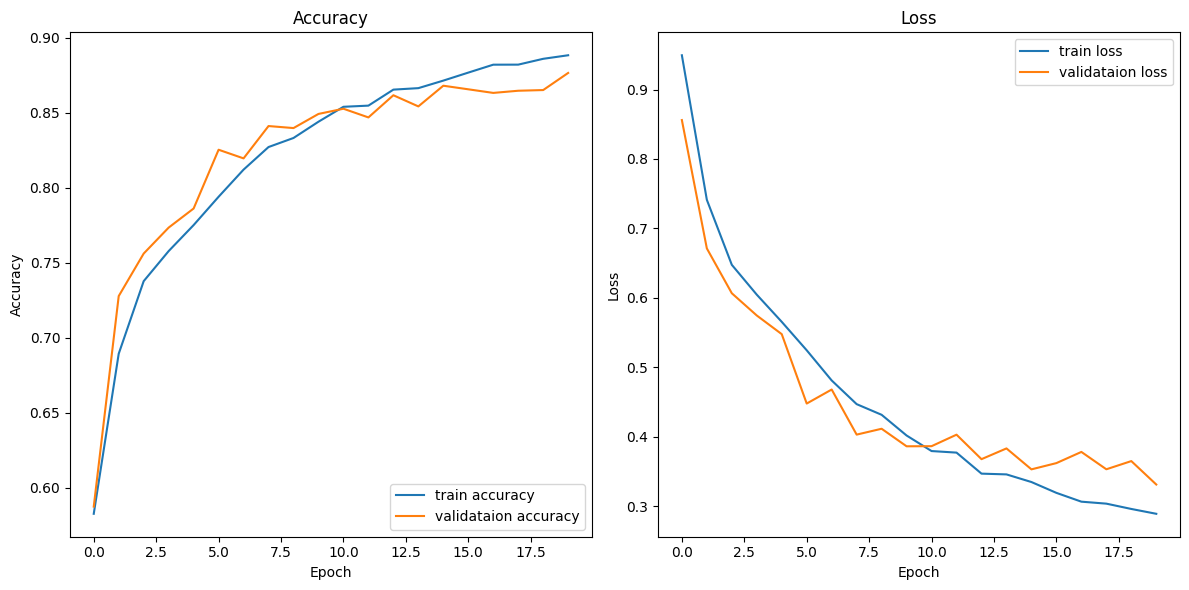

In [29]:
# Display learning curves
display_learning_curves(model_history)

## Predictions with U-Net model

Let's try the trained U-Net model on a few samples from the test dataset.

In [30]:
# count 部分：用于统计测试数据集中批次的数量，帮助了解数据集的规模。

# 统计 test_batches 中的批次数量
count = 0  # 初始化计数器
for i in test_batches:  # 遍历测试集的批次
    count += 1  # 每遇到一个批次，计数器加 1
print("number of batches:", count)  # 打印测试集中的批次数量

number of batches: 11


In [31]:
# create_mask：生成预测掩码，将模型输出的预测结果转换为每个像素的类别标签。
# 创建掩码函数，获取预测掩码中的类别标签
def create_mask(pred_mask, index=0):
    # 获取每个像素的预测类别，tf.argmax 返回指定轴上的最大值索引（即预测的类别）
    pred_mask = tf.argmax(pred_mask, axis=-1)  # 对最后一个维度进行操作，获取每个像素的预测类别
    pred_mask = pred_mask[..., tf.newaxis]  # 扩展维度，以符合图像的格式要求
    return pred_mask[index]  # 返回指定索引处的掩码（通常为第一个图像的掩码）


# show_predictions：从数据集中获取图像和掩码，显示原始图像、真实掩码以及模型预测的掩码，方便直观地查看模型的表现。
# 显示预测结果
def show_predictions(dataset=None, num=1):
    if dataset:  # 如果提供了数据集
        for image, mask in dataset.take(num):  # 从数据集中取 num 个样本
            pred_mask = unet_model.predict(image)  # 使用模型预测掩码

            # 设置图像的大小
            plt.figure(figsize=(15, 5))

            # 原始图像
            plt.subplot(1, 3, 1)  # 创建第一个子图：原始图像
            plt.imshow(tf.cast(image[0] * 255.0, tf.uint8).numpy())  # 将图像缩放到 [0, 255] 区间，并转换为 uint8 类型
            plt.title('Original Image')  # 设置子图标题为 "Original Image"

            # 真实掩码
            plt.subplot(1, 3, 2)  # 创建第二个子图：真实掩码
            plt.imshow(mask[0], cmap='viridis')  # 显示真实掩码，使用 'viridis' 色彩映射
            plt.title('True Mask')  # 设置子图标题为 "True Mask"

            # 预测掩码
            plt.subplot(1, 3, 3)  # 创建第三个子图：预测掩码
            plt.imshow(create_mask(pred_mask), cmap='viridis')  # 显示预测掩码，使用 'viridis' 色彩映射
            plt.title('Predicted Mask')  # 设置子图标题为 "Predicted Mask"

            # 显示图像
            plt.show()
    else:
        print("Dataset not provided")  # 如果没有提供数据集，打印提示信息


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


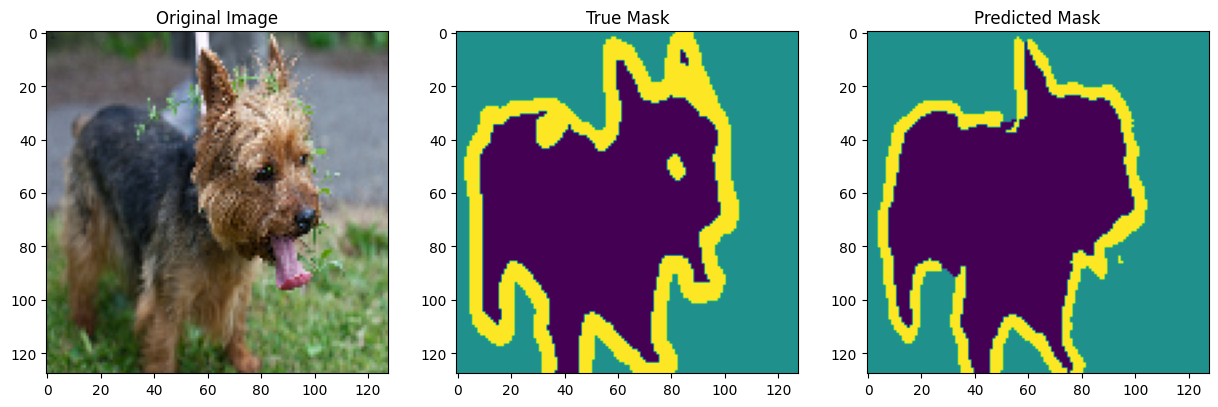

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


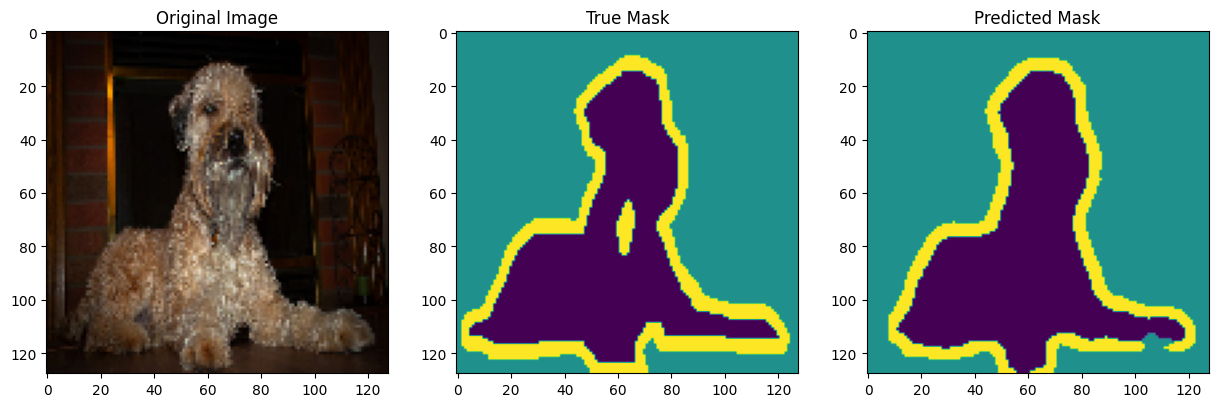

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


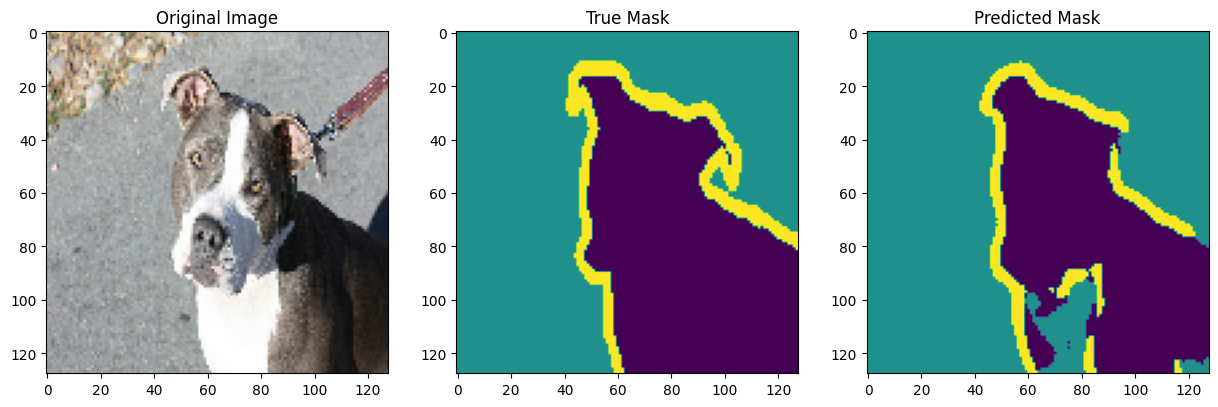

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


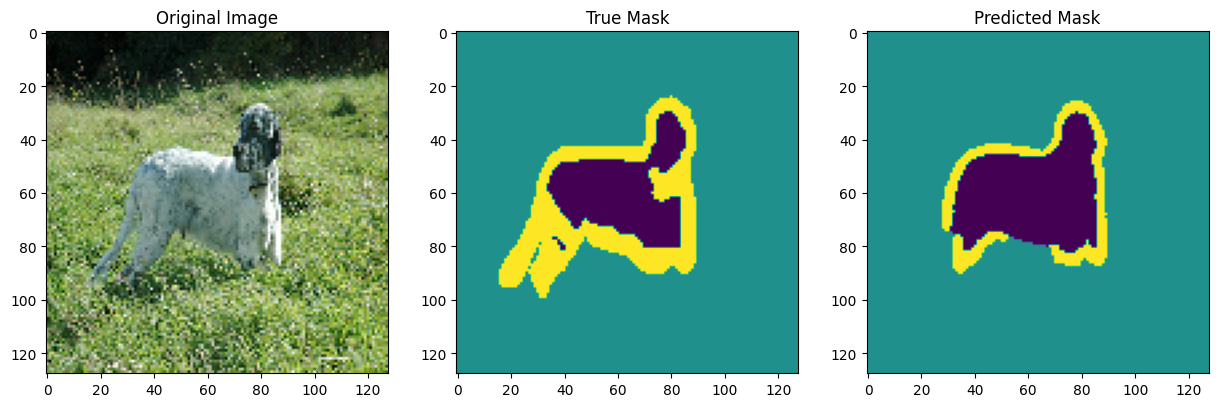

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


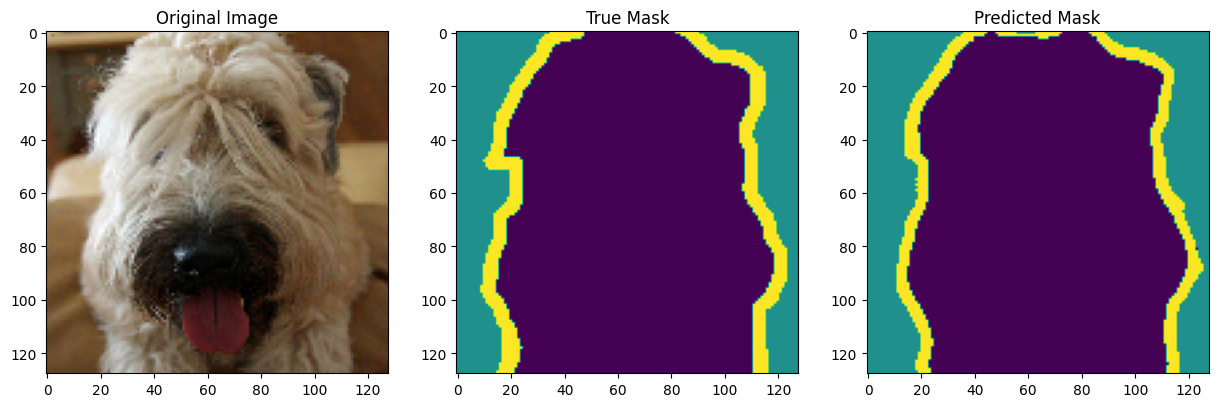

In [32]:
show_predictions(test_batches.skip(5), 5)


# skip(5)：这是 TensorFlow 数据集 (tf.data.Dataset) 提供的一个方法，作用是跳过前 5 个批次的数据。（例如，如果你已经看过前 5 个批次的数据，你可能想从第 6 个批次开始查看预测结果。）
# test_batches 是之前定义的测试数据集。这个数据集是按批次生成的，每个批次包含一部分图像和它们的标签（掩码）。通过 skip(5)，你告诉数据集在开始处理时跳过前 5 个批次，从第 6 个批次开始使用数据。
# 这是 show_predictions 函数的第二个参数，表示你希望展示 5 个批次的预测结果。



# 假设你的 test_batches 数据集中包含 20 个批次，每个批次可能有 64 张图片。
# 调用 test_batches.skip(5) 后，前 5 个批次的数据将被跳过，预测将从第 6 个批次开始。
# show_predictions 将从第 6 批次开始显示接下来的 5 个批次的结果。


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


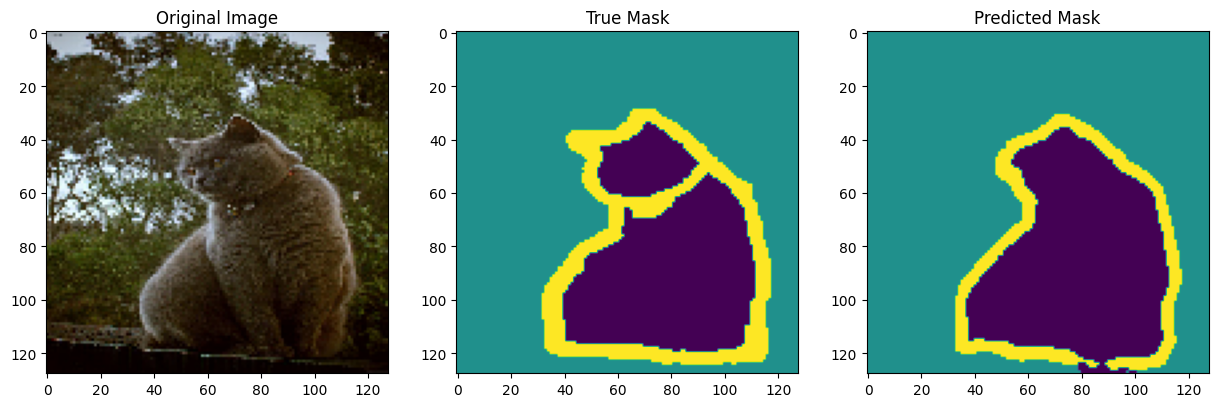

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


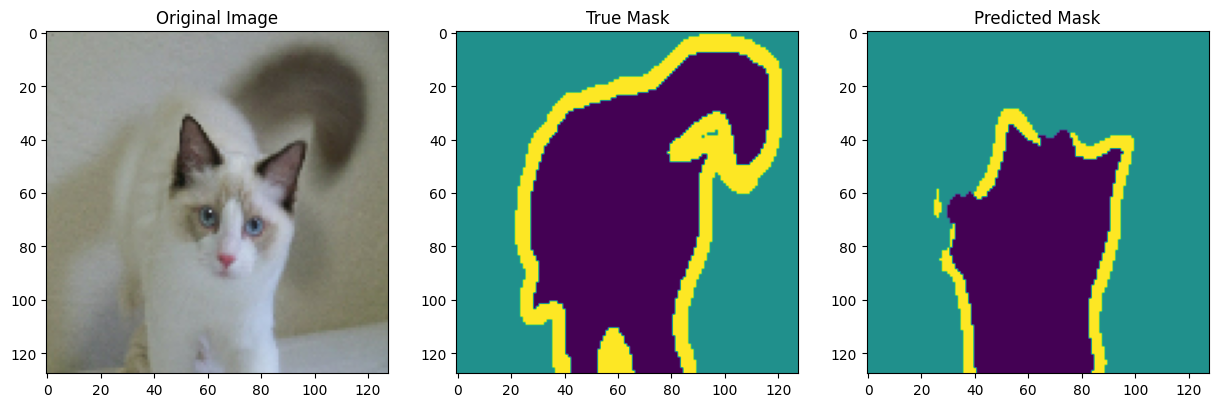

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


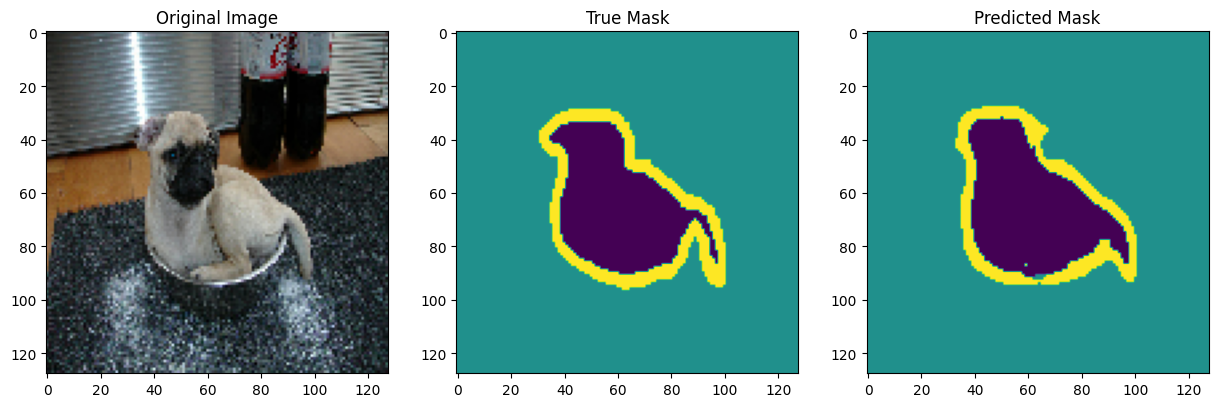

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


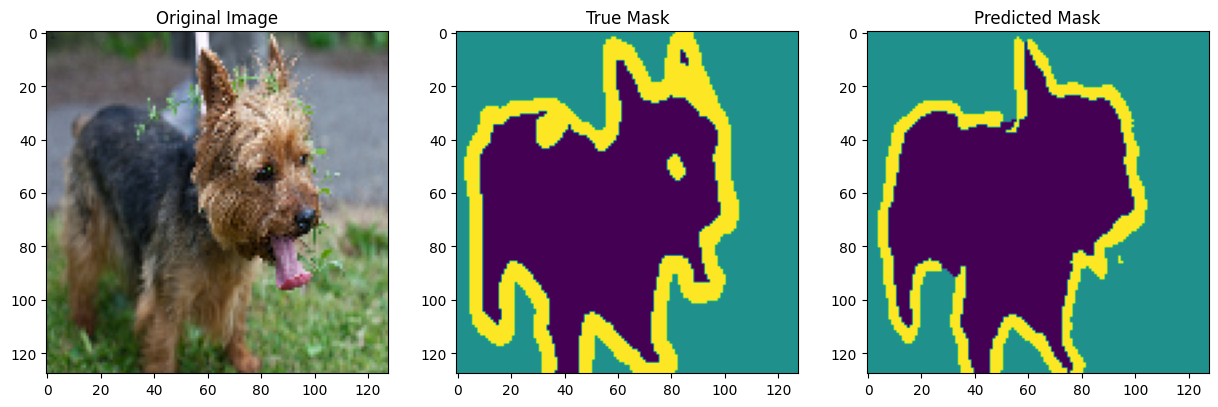

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


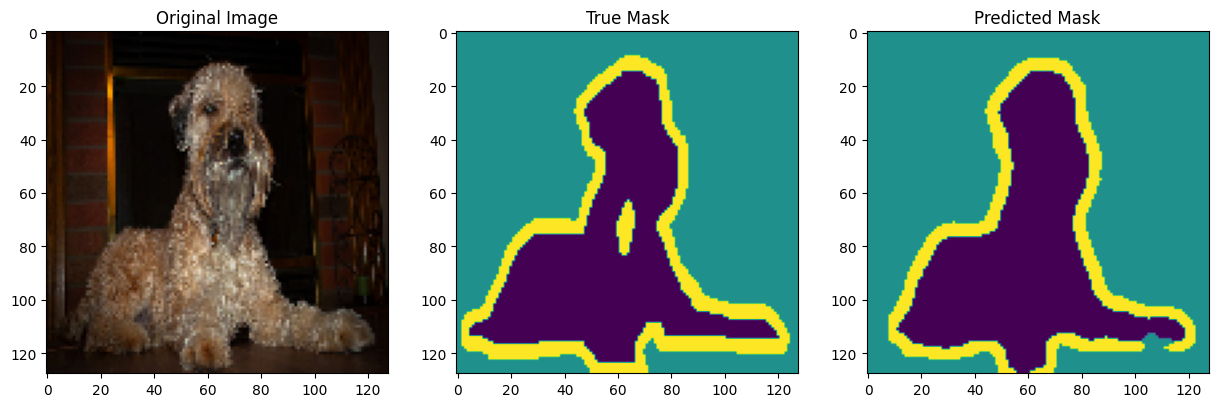

In [33]:
show_predictions(test_batches.skip(2), 5)

根据你上传的图像以及对 U-Net 分割任务的描述，我来详细解释一下这个图像和结果的含义。

### 1. **预测结果的作用**：
在图像分割任务中，模型输出的是一个**像素级别的分类结果**。你提到模型的返回结果并没有给出**预测的标签结果**，其实分割任务的输出是一张掩码图，掩码中的每个像素代表它所属的类别。根据你提供的图片，预测的结果并不仅仅是物体的边缘，而是整个图像的**语义分割**。

#### 具体看：
- **原始图像（Original Image）**：这是模型输入的原始图片（狗的图像）。
- **真实掩码（True Mask）**：这是训练数据中的真实标注（ground truth），即每个像素的正确标签。掩码通常包含几种颜色，表示图像中不同的物体或区域。
  - 在你展示的掩码图中，紫色区域表示宠物的身体，黄色部分表示边缘，绿色部分表示背景。
- **预测掩码（Predicted Mask）**：这是模型预测的结果，显示了模型认为每个像素应该属于哪个类别。颜色的分布与真实掩码类似，紫色区域表示宠物的身体，黄色为边缘，绿色为背景。

### 2. **为什么结果只看起来是“预测了边缘”**：
你提到模型似乎“只是预测了边缘”，其实这是由于**颜色的分布和掩码的显示方式**导致的误解。
- **黄色边缘**：掩码的颜色方案中，黄色通常表示物体的边界（边缘），这是分割模型重要的输出之一，因为边缘信息对于精确的分割至关重要。
- **紫色区域**：紫色代表物体的主体部分（在这个例子中是狗的身体）。模型不仅仅预测了边缘，还对整个物体（狗）进行了预测，只是因为紫色区域占据了大部分。

### 3. **关于“没有给出预测的标签结果”**：
其实，预测的掩码（Predicted Mask）就是模型的输出，它显示了每个像素的类别。具体的类别是通过颜色来区分的：
- **紫色**：宠物的身体。
- **黄色**：宠物的边缘。
- **绿色**：背景。

这个图像展示的是每个像素属于哪一类，这就是分割模型的输出。在使用过程中，你可以根据不同的像素值来提取相应的类别。

### 4. **模型的作用**：
这个预测结果的主要目的是**语义分割**，即为每个像素分类。这与**物体检测**不同，分割任务关注的是每个像素属于哪一类，而不是在图像中框出某个物体。

### 5. **具体的预测结果和标签类别的获取**：
- 如果你想获取具体的**标签**，你可以通过 `tf.argmax()` 函数将模型的输出转换为类别标签。每个像素会被分配到对应的类别（例如：背景、边缘、物体）。
- 你可以进一步将像素类别映射回到具体的标签，比如：背景 = 0，物体边缘 = 1，物体主体 = 2。

### 总结：
1. 模型的输出不是“仅仅预测了边缘”，而是对图像进行了完整的分割预测。黄色部分是边缘，紫色部分是物体主体，绿色部分是背景。
2. 图像分割的目标是为每个像素分配一个类别，这正是你的模型输出的内容。如果你希望看到具体的标签分类，可以通过处理 `Predicted Mask` 来获取每个像素的类别编号。

## Next steps
Now that you have an understanding of what image segmentation is and how it works, you can try this tutorial out with different intermediate layer outputs, or even different pretrained model. You may also challenge yourself by trying out the [Carvana](https://www.kaggle.com/c/carvana-image-masking-challenge/overview) image masking challenge hosted on Kaggle.

You may also want to see the [Tensorflow Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection) for another model you can retrain on your own data.


下一步
现在你已经了解了什么是图像分割以及它是如何工作的，你可以用不同的中间层输出，甚至不同的预训练模型来尝试本教程。您还可以尝试 Kaggle 上的 Carvana 图像屏蔽挑战，挑战一下自己。

您还可以查看 Tensorflow Object Detection API，了解另一个可以在自己的数据上重新训练的模型。

In [ ]:
# detectron2, segment anything model

<center><a target="_blank" href="https://academy.constructor.org/"><img src=https://lh3.googleusercontent.com/d/1EmH3Jks5CpJy0zK3JbkvJZkeqWtVcxhB width="400" style="background:none; border:none; box-shadow:none;" /></a> </center>
<hr /># 补充：U模型
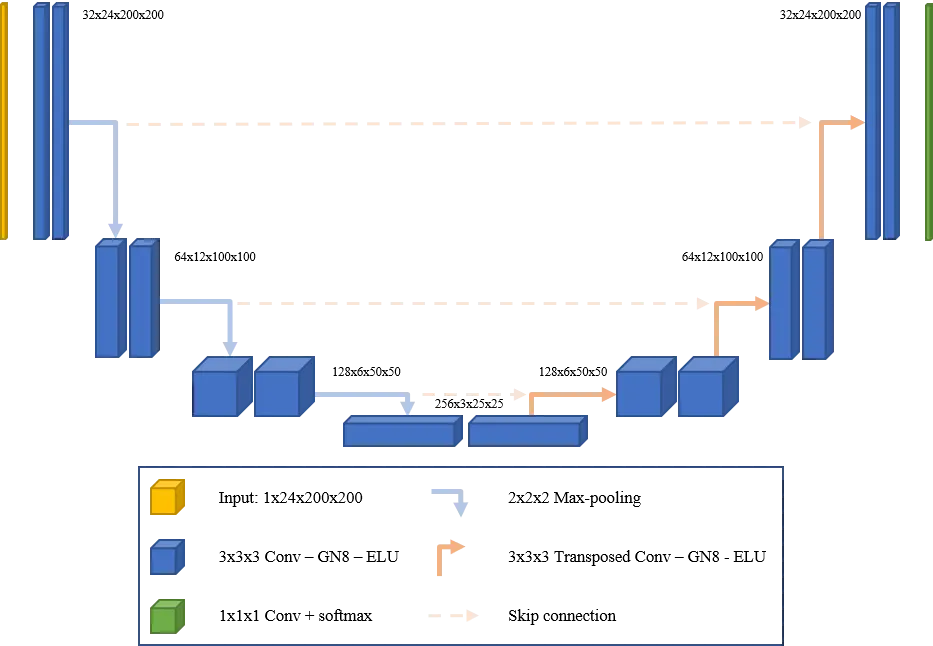
---
# 图像解释

这张图展示了一个 **U-Net** 模型的结构。U-Net 是一种经典的图像分割模型，它的名字来源于其结构像字母 "U"。模型分为三大部分：**编码器（左侧）**、**瓶颈（底部）** 和 **解码器（右侧）**，同时包含了**跳跃连接（Skip Connections）**。接下来，我将逐步分析图中的每个部分。

### 1. **编码器（Encoder，左侧）**：
   - **位置**：图像的左侧，由一系列的蓝色块组成。
   - **作用**：提取输入图像的特征，并通过**卷积层（Conv2D）**和**最大池化层（Max Pooling）**逐步下采样，减少图像的空间分辨率。
   - **具体流程**：
     - 每层蓝色的长方体代表卷积操作（通常是两次卷积，类似于 `double_conv_block`）。
     - 每次卷积后，通过垂直向下的箭头执行一次池化操作，减少图像尺寸。每次池化后，图像的宽度和高度会缩小，而深度（特征通道数）会增加，这样可以提取到更加复杂的特征。
   - **结果**：编码器的作用是将原始图像转换为不同分辨率的特征图，逐渐从原始输入图像提取出更高级的语义信息。

### 2. **瓶颈（Bottleneck，底部）**：
   - **位置**：图像的最底部，由两个蓝色块组成。
   - **作用**：瓶颈是模型的最底部部分，连接编码器和解码器。它负责提取输入图像的最深层次的全局语义信息。
   - **具体流程**：
     - 瓶颈中的两个蓝色块代表着两次卷积操作（类似 `double_conv_block`）。此时特征图的空间分辨率已经很低，但特征通道数很高，代表着图像中的全局信息。
   - **结果**：瓶颈部分是模型中的信息压缩点，它将图像的空间维度压缩到最小，保留全局信息，为解码器后续的恢复过程提供基础。

### 3. **解码器（Decoder，右侧）**：
   - **位置**：图像的右侧，由一系列的蓝色块和上升的箭头组成。
   - **作用**：逐步恢复图像的空间分辨率，生成最终的分割掩码。
   - **具体流程**：
     - 解码器的每个步骤都包含一次**上采样（Up-sampling）**操作（橙色箭头），用于扩大特征图的空间分辨率。
     - 上采样后，通过两次卷积操作（蓝色块），进一步处理特征图，逐步恢复图像的空间细节。
     - 解码器的最后一层通常会输出与输入图像大小相同的特征图，作为分割掩码。
   - **结果**：解码器通过上采样逐步恢复图像的分辨率，并结合编码器传递来的高分辨率特征生成精细的分割掩码。

### 4. **跳跃连接（Skip Connections，虚线箭头）**：
   - **位置**：图中横跨编码器和解码器之间的**虚线**箭头。
   - **作用**：在每次下采样之前，编码器保存高分辨率的特征图，通过跳跃连接传递到解码器相应层，与解码器的上采样特征拼接（Concatenation），帮助恢复图像细节。
   - **具体流程**：
     - 跳跃连接直接将编码器中的特征图与解码器中的上采样特征图拼接，使得解码器可以同时利用低分辨率的语义信息和高分辨率的空间细节。
     - 这种机制保证了 U-Net 模型在恢复图像分辨率的过程中，能够保留足够的细节，生成更加精确的分割掩码。
   - **结果**：跳跃连接帮助解码器恢复图像的边缘和细节，避免因多次下采样而丢失的细节信息。

### 5. **输出（Output，右上角）**：
   - **位置**：解码器的最右端，绿色块表示最终输出。
   - **作用**：生成一个与输入图像相同大小的分割掩码。
   - **具体流程**：
     - 解码器经过上采样和卷积操作后，最后通过一个**1x1 卷积层**，将特征图映射到输出的分割掩码（每个像素的类别）。
     - 输出的分割掩码用于表示图像中的每个像素属于哪一类（例如：背景、物体边缘、物体主体）。

### 图解总结：
1. **黄色的输入块**：表示输入图像。
2. **蓝色块**：表示卷积操作（特征提取）。
3. **橙色箭头**：表示上采样操作，恢复图像分辨率。
4. **虚线箭头**：表示跳跃连接，将编码器的高分辨率特征传递给解码器。
5. **绿色块**：表示模型的输出结果，即分割掩码。

### 整体工作流程：
1. 输入图像经过**编码器**，逐层下采样并提取特征。
2. 到达**瓶颈**部分，提取全局语义信息。
3. **解码器**通过上采样逐步恢复图像的空间分辨率，同时结合**跳跃连接**的高分辨率特征，生成精细的分割结果。
4. 最终输出的**分割掩码**与输入图像的大小相同，表示每个像素的分类结果。

### 总结：
- **编码器**：逐步下采样，提取更高级别的语义特征。
- **瓶颈**：最底层的全局特征提取部分，提取最深层次的语义信息。
- **解码器**：通过上采样恢复图像分辨率，生成分割掩码。
- **跳跃连接**：将编码器的高分辨率特征传递给解码器，帮助恢复图像细节。

这一架构是 U-Net 的经典设计，通过编码器、解码器和跳跃连接的结合，既能够捕捉全局信息，又能够保留细节，广泛应用于图像分割任务。

# 模块解释
### 1. 编码器部分（下采样，Encoder/Down-sampling）：

**功能**：提取图像的高级特征。
**具体操作**：输入图像通过多层卷积和最大池化操作，逐步减少特征图的空间分辨率，增加特征图的深度。
- **卷积操作（Conv 3x3 + ReLU）**：每一层卷积都会提取不同层次的特征。
- **最大池化（Max Pool 2x2）**：每次池化将图像的尺寸缩小一半（例如从 128x128 到 64x64），减少空间信息，但保留高级语义信息。

---

### 2. 跳跃连接（Skip Connections）：
**功能**：从编码器部分的早期层保存高分辨率特征信息，并在解码器部分传递这些信息。
**具体操作**：跳跃连接（Skip Connections）在 U-Net 模型中的实现，是为了在解码器中恢复图像细节时，结合编码器中保留的高分辨率特征，从而提高图像分割的精确性

解码器部分 通过上采样操作逐步恢复图像的空间分辨率。然而，上采样本身只能恢复分辨率，无法恢复高质量的细节特征，特别是物体的边缘和复杂结构。

这时，跳跃连接将编码器中的高分辨率特征传递到解码器相应层，将其与解码器上采样后的特征图拼接（concatenate）。这个拼接操作将来自编码器的高分辨率细节与解码器中的深层语义特征结合在一起，帮助解码器逐步恢复图像的边缘和其他精细信息。

---

### 3. 解码器部分（上采样 + 分割预测，Decoder/Up-sampling & Segmentation Prediction）：

**功能**：逐步恢复图像的空间分辨率，生成像素级的分割掩码。

**具体操作**：
- **上采样（Up-sampling）**：通过上采样操作（例如反卷积 ConvTranspose2D 或插值 interpolation）逐步将特征图的尺寸从小恢复到接近输入图像的大小。每次上采样将图像尺寸扩大一倍（例如从 64x64 到 128x128），通过卷积操作（Conv 3x3 + ReLU）进一步提取和细化特征。
  
- **特征拼接（Feature Concatenation）**：将跳跃连接中编码器保存的高分辨率特征与上采样后的特征图拼接，确保解码器能够同时利用深层的高级语义信息和早期的空间细节。

- **卷积操作（Conv 3x3 + ReLU）**：通过卷积操作进一步处理上采样后的特征图，逐步细化图像的局部特征，使得分割结果更加精准。

- **1x1 卷积（Conv 1x1）**：解码器部分的最后一层是一个 1x1 的卷积层，用来将特征图的通道数映射到输出类别的数量。每个像素被分配一个概率值，表示该像素属于某个类别（例如背景、物体边缘、物体主体等）。

**输出结果**：最后，通过解码器生成一个分割掩码，其尺寸与输入图像相同。每个像素在掩码中对应一个类别，从而完成分割任务。

---

### 图像分割的具体步骤：

1. **输入图像传递给 U-Net：**
   - 图像首先进入 U-Net 的**编码器部分**，编码器逐层提取图像特征并缩小图像尺寸。

2. **编码特征逐层提取：**
   - 在编码器中，图像通过一系列卷积和池化操作逐步减少尺寸，同时获取更高层次的特征，这些特征代表了图像的全局信息。

3. **跳跃连接保存高分辨率特征：**
   - 编码器每次下采样的高分辨率特征被保留，并传递给解码器相应的层，确保解码器能够结合全局特征和局部细节恢复图像。

4. **解码器进行上采样和拼接：**
   - 解码器通过上采样逐步恢复图像的尺寸。在每次上采样后，解码器将与跳跃连接中的高分辨率特征图进行拼接，以帮助恢复图像中的空间信息和细节。

5. **最终生成像素级分割掩码：**
   - 解码器的最后一层使用 1x1 卷积将特征图映射到不同的类别（如背景、物体主体等），每个像素被分配一个类别标签。最终输出的分割掩码与输入图像的尺寸一致，模型为每个像素分配了一个类别，完成分割任务。

---

- **下采样（Down-sampling）：**用于减少图像尺寸和提取更高级别的语义特征，通常用于编码器部分，以降低空间维度，聚焦大尺度信息。

- **上采样（Up-sampling）：**用于恢复图像尺寸，生成像素级别的分割掩码，通常用于解码器部分，结合细节信息恢复图像结构。



**`NUM_EPOCHS`** 和 **`BATCH_SIZE`** 是深度学习模型训练中的两个重要概念，它们在模型如何遍历和处理数据方面有不同的作用。让我详细解释它们的区别和联系：

### 1. **`NUM_EPOCHS`**（轮次）：
   - **定义**：`NUM_EPOCHS` 表示模型在训练过程中完整遍历整个训练数据集的次数。每次完整遍历称为一个 **epoch**（轮次）。
   - **解释**：假设你的训练集有 3680 张图像，设置 `NUM_EPOCHS = 20`，这意味着模型将在 20 个 epoch 中每次都完整遍历这 3680 张图像。
   - **作用**：多个 epoch 的训练有助于模型反复学习数据中的模式，使得参数（如权重和偏置）能够不断调整和优化。

### 2. **`BATCH_SIZE`**（批次大小）：
   - **定义**：`BATCH_SIZE` 是模型每次训练时处理的样本数量。模型不会一次性把整个训练集放入内存进行计算，而是分批次地处理数据，每次使用一小部分数据（即一个 batch）。
   - **解释**：假设 `BATCH_SIZE = 64`，这意味着模型每次只会从训练集中取 64 张图像进行前向传播和反向传播，然后更新权重。整个训练集会被分成多个 batch，每次训练只会处理一个 batch 的数据。
   - **作用**：批次训练使得模型可以在有限的内存下处理大规模数据集，同时也能提高梯度更新的稳定性。

### **`NUM_EPOCHS` 和 `BATCH_SIZE` 的区别与联系**：

- **区别**：
  - **`NUM_EPOCHS`**：决定了模型在训练期间**遍历整个训练集的次数**。假设 `NUM_EPOCHS = 20`，意味着模型将遍历训练集 20 次，每次都从头到尾学习所有的样本。
  - **`BATCH_SIZE`**：决定了模型**每次迭代使用多少数据进行更新**。数据集会被按 `BATCH_SIZE` 分成若干小批次进行训练，而不是一次性处理所有数据。

- **联系**：
  - 在每个 epoch 中，模型会根据 `BATCH_SIZE` 将训练数据分成若干批次。
  - **一个 epoch = 完整地遍历一次整个数据集**，而一个 epoch 会包含多个批次（batch）。
  - **`STEPS_PER_EPOCH`** 表示在一个 epoch 中，模型一共要处理多少个批次：
    - 公式为 `STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE`，即用训练集样本总数除以批次大小。
    - 假设 `TRAIN_LENGTH = 3680` 和 `BATCH_SIZE = 64`，则 `STEPS_PER_EPOCH = 3680 // 64 = 57`。这意味着模型在一个 epoch 中会训练 57 个批次，每个批次处理 64 张图像。

### 举例说明：
假设：
- **训练集样本总数 `TRAIN_LENGTH = 3680`** 张图片
- **`BATCH_SIZE = 64`**
- **`NUM_EPOCHS = 20`**

#### 1. 一个 **batch** 训练的过程：
   - 模型一次取 64 张图片，进行前向传播、计算损失、反向传播和更新权重，这就称为处理了一个 **batch**。
   - 每个 batch 处理完后，模型会更新一次权重。
   - 如果 `BATCH_SIZE = 64`，则在每个 batch 处理中模型只会看到 64 张图片。

#### 2. 一个 **epoch** 训练的过程：
   - 一个 **epoch** 就是模型完整遍历一次整个数据集的过程。
   - 因为 `TRAIN_LENGTH = 3680`，`BATCH_SIZE = 64`，所以在一个 epoch 中，模型会处理 57 个批次（**STEPS_PER_EPOCH = 57**），直到所有 3680 张图片都被处理一次。
   - 每处理一个批次，模型会更新一次权重。整个 epoch 完成后，模型已经更新了 57 次权重。

#### 3. **NUM_EPOCHS = 20**：
   - 如果你设置 `NUM_EPOCHS = 20`，那么模型将会在训练集中遍历 20 次，也就是进行 20 轮完整训练。
   - 每个 epoch 都会包含 57 个 batch，整个训练过程中模型将执行 `20 * 57 = 1140` 次权重更新。

### 直观理解：
- **`BATCH_SIZE`** 是指模型一次处理的数据量。数据集太大时，无法一次性放进内存，因此需要分批处理。
- **`NUM_EPOCHS`** 是指模型需要把整个数据集看多少遍，通常是为了确保模型能够充分学习数据中的模式和规律。

### 总结：
- **`BATCH_SIZE`**：控制模型一次处理的数据量，较小的 `batch` 可以在有限内存下训练模型。
- **`NUM_EPOCHS`**：控制模型完整遍历整个数据集的次数，多个 epoch 能够帮助模型反复学习数据中的模式。
- **STEPS_PER_EPOCH**：表示在一个 epoch 中需要多少个批次，才能遍历整个数据集。

希望这些解释能帮助你理解 `NUM_EPOCHS` 和 `BATCH_SIZE` 的区别与联系。

是的，你的理解是正确的！在每个 **epoch** 中，模型会遍历整个训练集，计算损失函数，并通过损失值的反馈来调整权重。让我们分步骤详细解释训练过程，以帮助你更好地理解这个过程：

### **训练一个 epoch 的流程：**

1. **前向传播（Forward Pass）**：
   - 模型从训练集中读取一个批次（batch）的数据（假设 `BATCH_SIZE = 64`），然后将这些数据输入模型。
   - 模型根据当前的权重对输入数据进行一系列计算（通过卷积层、激活函数等），最终输出一个预测值。

2. **计算损失（Loss Calculation）**：
   - **损失函数**（例如 `sparse_categorical_crossentropy`）用来计算模型预测值和真实标签之间的差异。
   - 损失函数输出一个损失值（通常是一个标量），表示模型当前预测的误差大小。损失值越大，意味着模型的预测与真实标签的差距越大。

3. **反向传播（Backpropagation）**：
   - 通过**反向传播算法**，模型会根据损失值的大小，计算出每个参数（权重和偏置）对损失的贡献，也就是梯度。
   - 这一步是从输出层开始，反向逐层传播到输入层，计算各层的梯度。

4. **更新权重（Weight Update）**：
   - 根据计算出的梯度，模型通过**优化器**（如 Adam 或 SGD）来更新权重和偏置，使得下次预测时损失值减小。
   - 更新的过程通常如下：`新权重 = 旧权重 - 学习率 * 梯度`。这意味着模型会朝着减少损失的方向更新参数。

5. **处理下一个批次（Next Batch）**：
   - 模型完成了一个批次（batch）的训练之后，会继续从训练集中取下一个批次的数据，重复上述步骤。
   - 一个 epoch 包含了多个批次，直到模型遍历了整个训练集。

6. **完成一个 epoch**：
   - 在一个 epoch 结束时，模型已经根据所有训练样本更新了多次权重。
   - 完成一个 epoch 后，模型可能会在验证集上评估当前的性能（例如，计算准确率），以观察模型是否有进步。

7. **重复多次 epoch**：
   - 当你设置 `NUM_EPOCHS = 20`，整个过程会重复 20 次。每次遍历完整个训练集后，模型会通过**反馈损失**和**反向传播**不断调整权重，目标是逐步减小损失值，提高预测的准确性。

### 简单总结训练的步骤：

- **批次（batch）**：模型一次处理的样本数（例如 64 张图像）。
- **前向传播**：模型计算预测值。
- **计算损失**：损失函数衡量预测与真实标签的差异。
- **反向传播**：根据损失值计算每个参数的梯度。
- **权重更新**：通过优化器根据梯度调整权重，使得模型更准确。
- **完整遍历数据集（epoch）**：一个 epoch 包括多个批次的训练，直到遍历完所有训练数据。

### **每个 epoch 的具体内容：**
- 在每个 epoch 中，模型会经过 **若干次批次的前向传播、计算损失、反向传播和更新权重**。
- 每完成一个 epoch，模型的参数都会有所调整，以尽量减小损失函数的值，从而提高模型的预测能力。

### **最终目标**：
通过多次 epoch，模型不断学习训练数据中的模式，权重逐渐调整到一个最佳值，使得模型能够对未见过的数据（测试集或验证集）进行有效的预测。

### 例子：
假设你有以下设置：
- **训练数据集**：3680 张图像
- **`BATCH_SIZE`**：64
- **`NUM_EPOCHS`**：20

那么，训练过程如下：
1. 在**第一个 epoch**：
   - 模型会处理 3680 / 64 = 57 个批次（`STEPS_PER_EPOCH = 57`）。
   - 每个批次都会计算损失并更新一次权重。
   - 模型遍历完所有 3680 张图像，完成第一个 epoch。

2. **接下来的 19 个 epoch**：
   - 模型重复这一过程 19 次。每次 epoch 结束后，模型会在验证集上评估当前的性能，并调整学习策略。
   - 模型的权重会不断被调整，直到完成所有 20 个 epoch。

### 总结：
- **每个 epoch**：模型会完整遍历一次训练集，逐批次计算损失和更新权重。
- **反向传播**：通过计算梯度和更新权重，模型不断学习，目标是降低损失，提升预测效果。
- **多轮次训练（epochs）**：训练多次 epoch 允许模型逐步收敛到更优的解，从而提升模型的泛化能力，尤其是对于新的测试数据。

要判断一个模型是否**收敛**，通常是通过观察训练和验证的**损失曲线**和**准确率曲线**。收敛意味着模型在经过一定的训练轮次后，损失逐渐减小，准确率逐渐提高，并达到稳定状态。以下是具体方法：

### 1. **通过损失曲线判断收敛**：

- **训练损失（Train Loss）**：模型在训练集上的损失。
- **验证损失（Validation Loss）**：模型在验证集上的损失。

#### 理想情况下：
- 随着训练的进行，**训练损失**应该逐渐减小。
- 同时，**验证损失**也应当逐渐减小，直到趋于稳定（不再大幅波动）。
- 如果损失曲线趋于平坦或呈下降趋势，且验证损失不再显著上升，表示模型正在收敛。

#### 关键点：
- **稳定的验证损失**：验证损失曲线应该趋于平稳，不能继续剧烈波动或明显上升。如果验证损失在训练早期快速下降后逐渐趋于平稳，表明模型正在收敛。
- **损失减小的速度**：损失值不再显著下降，也可能是模型收敛的信号，但这并不一定是最终收敛的标志，仍需关注验证损失的表现。

### 2. **通过准确率曲线判断收敛**：

- **训练准确率（Train Accuracy）**：模型在训练集上的准确率。
- **验证准确率（Validation Accuracy）**：模型在验证集上的准确率。

#### 理想情况下：
- **训练准确率** 应该逐渐提升，并趋于稳定。
- **验证准确率** 也应该逐渐提高并趋于平稳，直到不再明显波动。
- 如果训练准确率和验证准确率趋于稳定，且两者相差不大，说明模型在学习数据中的模式，且有良好的泛化能力。

#### 关键点：
- **验证准确率接近训练准确率**：如果验证准确率接近训练准确率，并且都趋于稳定，表示模型已接近收敛，并且有较好的泛化能力。
- **训练准确率提升但验证准确率下降或停滞**：如果训练准确率继续提升，但验证准确率停滞或下降，可能表明模型出现过拟合，但在某种程度上它也表示训练本身已经收敛。

### 如何通过图形看收敛？

#### 理想的收敛曲线示例：

1. **损失曲线**：
   - **训练损失**（蓝线）和 **验证损失**（橙线）都会随着 epoch 增加逐渐下降，最终趋于平稳，表示模型在减少误差并且已经达到了最优状态。
   - 当验证损失趋于稳定时，模型不再显著改进，这就是收敛的标志。

2. **准确率曲线**：
   - **训练准确率**和 **验证准确率**逐渐上升，最终趋于稳定，并且两者之间没有太大差距。
   - 验证准确率不再显著上升，表明模型已经学习到了数据中的模式。

#### 非理想的情况：
1. **过拟合**：验证损失开始上升，而训练损失继续下降，说明模型开始记住训练数据的细节，但无法在新数据上泛化。
2. **欠拟合**：训练损失和验证损失都保持在较高的水平，模型没有足够学习到数据中的模式，表示模型复杂度不足或训练不足。

### 图示示例（假设显示在 `display_learning_curves()` 中）：

```plaintext
   |                               |                                
  1|        _______   <- Accuracy   |   _______ <- Validation Accuracy
   |       /       \                |  /
  0|______/         \_______________|_/_________________ Epochs ---->
```

- 曲线逐渐收敛，验证和训练的准确率趋向稳定，验证损失停止波动，验证准确率不再显著上升。

### 总结：

- **损失曲线是否平稳**：如果损失曲线在经过一定的训练后趋于平稳且不再剧烈波动或显著上升，模型可能已经收敛。
- **准确率曲线是否稳定**：如果训练和验证的准确率都逐渐趋于平稳，并且两者相差不大，表示模型可能收敛。
- **训练和验证损失趋同**：如果训练损失和验证损失都在降低，且验证损失保持稳定或略微上升，说明模型接近收敛。

在 TensorFlow 数据集中，**划分批次是否是按顺序进行的**，取决于你如何设置数据集的操作。在默认情况下，如果你没有对数据集进行任何打乱操作（如调用 `shuffle()` 函数），那么批次的划分是**按顺序**进行的。

### 默认情况下（顺序划分）：
如果你直接使用 `.batch()` 来分批数据，而没有任何打乱（shuffle）操作，数据集中的样本会**按顺序**被分成批次。这意味着：
- 数据集中的样本按它们在原始数据集中的顺序进行划分。
- 每个批次的样本都是按照数据集的顺序从头到尾分割。

#### 示例：
```python
dataset = tf.data.Dataset.range(10)  # 创建一个包含 0 到 9 的数据集
batched_dataset = dataset.batch(3)  # 将数据集按顺序划分为批次，每个批次包含 3 个元素

for batch in batched_dataset:
    print(batch.numpy())
```
输出：
```
[0 1 2]
[3 4 5]
[6 7 8]
[9]
```
在这个例子中，批次是按顺序划分的：每 3 个数据作为一个批次，按顺序处理。

### 通过 `shuffle()` 打乱数据（随机划分）：
如果你希望在批次划分之前，**随机打乱**数据顺序，那么你可以在 `.batch()` 之前调用 `.shuffle(buffer_size)`，这样批次中的样本就不会按顺序分配，而是打乱后的样本。

#### 示例：
```python
dataset = tf.data.Dataset.range(10)  # 创建一个包含 0 到 9 的数据集
shuffled_dataset = dataset.shuffle(10)  # 打乱数据顺序
batched_dataset = shuffled_dataset.batch(3)  # 将打乱后的数据划分为批次

for batch in batched_dataset:
    print(batch.numpy())
```
输出（可能不同，每次运行都会打乱）：
```
[6 2 5]
[9 1 0]
[8 4 7]
[3]
```
在这个例子中，数据集经过 `shuffle()` 打乱后，再按批次划分，结果中的样本顺序已经不再是原始的顺序。

### 总结：
- **按顺序划分**：如果你没有调用 `shuffle()`，那么数据集会按照原始顺序被划分成批次。
- **打乱划分**：如果你在批次划分之前使用了 `.shuffle()`，那么批次中的样本顺序会被随机打乱。